In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data prep
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin  # building custom transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import joblib  # saving model to pickle

In [2]:
# Some common settings
sns.set()
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)

In [3]:
# Some common variables
PATH_DATA = "./datasets"

# Get the dataset

In [4]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p {PATH_DATA}

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -n {PATH_DATA}/house-prices-advanced-regression-techniques.zip -d {PATH_DATA}

Archive:  ./datasets/house-prices-advanced-regression-techniques.zip


In [6]:
df_train_raw = pd.read_csv(f'{PATH_DATA}/train.csv')
df_test_raw = pd.read_csv(f'{PATH_DATA}/test.csv')

In [7]:
print(df_train_raw.shape, df_test_raw.shape)

(1460, 81) (1459, 80)


## Correct the data types

In [8]:
# Make a copy to avoid modifying the original dataset
df = df_train_raw.copy()

# Make the Id column as index
df.set_index('Id', inplace=True)

### Numerical type

In [9]:
# Display only numerical type
df.select_dtypes('number').head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [10]:
# Columns which should be categorical
cols = ['MSSubClass', 'OverallQual', 'OverallCond']

# Keep track of the numerical columns
num_cols = list(df.select_dtypes('number').columns)
num_cols.remove('MSSubClass')
num_cols.remove('OverallQual')
num_cols.remove('OverallCond')

In [11]:
# Number of numerical features
len(num_cols)

34

### Categorical type

In [12]:
# Display all non-numerical type
df.select_dtypes('object').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [13]:
### Columns which are categorical
cat_cols = list(df.select_dtypes('object').columns)
# Add the 3 categorical columns identified earlier in the numerical section
for col in cols:
    cat_cols.append(col)
    
### Ordering ordinal features which may help our EDA
# columns with 1-10 ratings
cond_cols = ['OverallQual', 'OverallCond']
cat_condition = pd.api.types.CategoricalDtype(ordered=True)
# columns with a 5-grade rating
grade5_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', \
               'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
cat_grade5 = pd.api.types.CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True)

In [14]:
# Number of categorical features
len(cat_cols)

46

### Data type conversion

In [15]:
df[cat_cols] = df[cat_cols].astype('category')
df[cond_cols] = df[cond_cols].astype(cat_condition)
df[grade5_cols] = df[grade5_cols].astype(cat_grade5)

# EDA

<hr>

**Summary:** The housing dataset contains 1460 records of past housing sales, with 34 numerical features and 46 categorical features. From the EDA process below, there are a few observations:

* The dependent variable `SalePrice` is right skewed. We'll perform a log transformation.
* Some independent variables are not in the perfect shape. Some of them are skewed, some of them have multicollinearity, and some of them shows heteroscedasticity. We will try to apply log transformation to some of them and fix the skewness.

As for missing values, there are a 5 columns with >47% missing values, and we will drop those features. Other than that, for numerical features, we will impute from the median. For categorical features, we will fill with 'NA'. Note that there are unseen category (i.e., columns with missing values in the test set but not in training set), and we will ignore them in the test set's one hot encoding to make the model generalize better.

Lastly, we have some success in creating new feature out from those year-related and area-related variables. `Year_built_to_sold`, `Year_remod_to_sold`, `Year_garageblt_to_sold`, `TotalArea` all have quite a good correlation with the SalePrice.

<hr>

In [16]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0


## Distribution

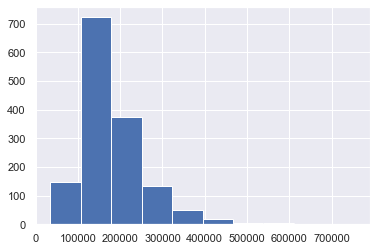

In [17]:
# Check the dependent variable distribution
df['SalePrice'].hist()

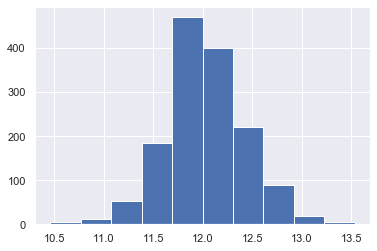

In [18]:
# The dependent variable's distribution after log transformation
np.log(df['SalePrice']).hist()

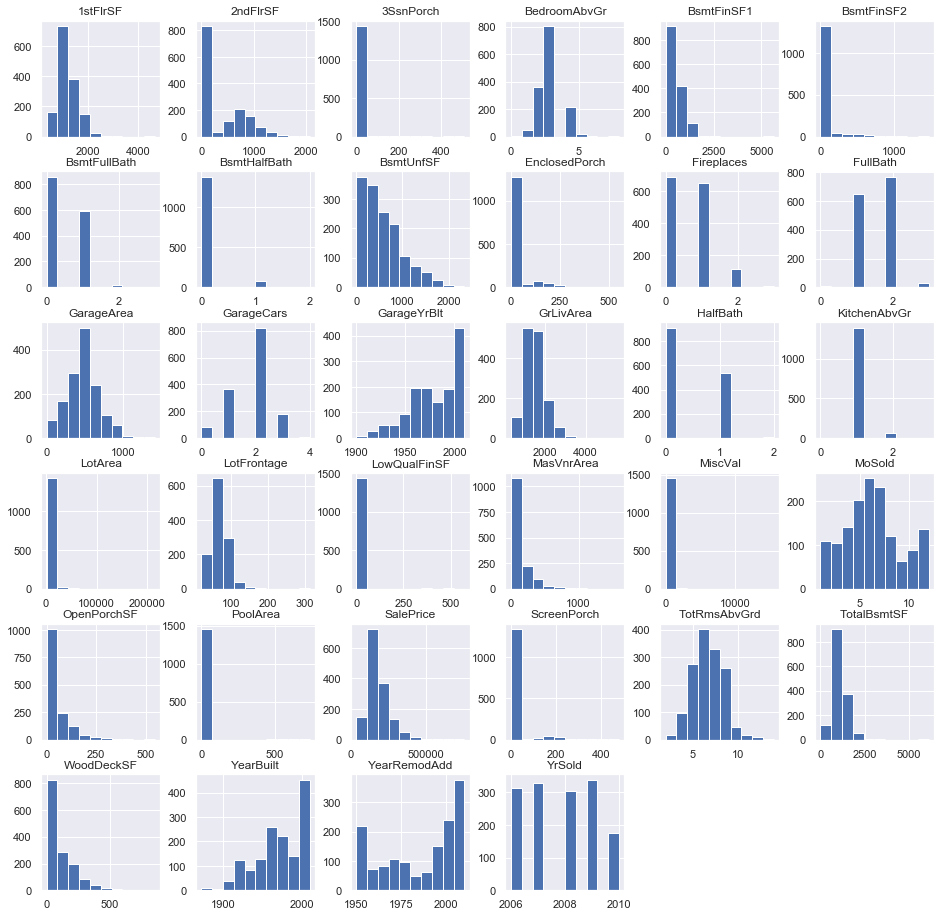

In [19]:
# The independent variables distribution
df[num_cols].hist(figsize=(16, 16))
plt.show()

> There are year-related features (i.e., `GarageYrBlt`, `YearBuilt`, `YearRemodAd`, `YrSold`) do not fit as numerical values. We are going to create new features out of these.

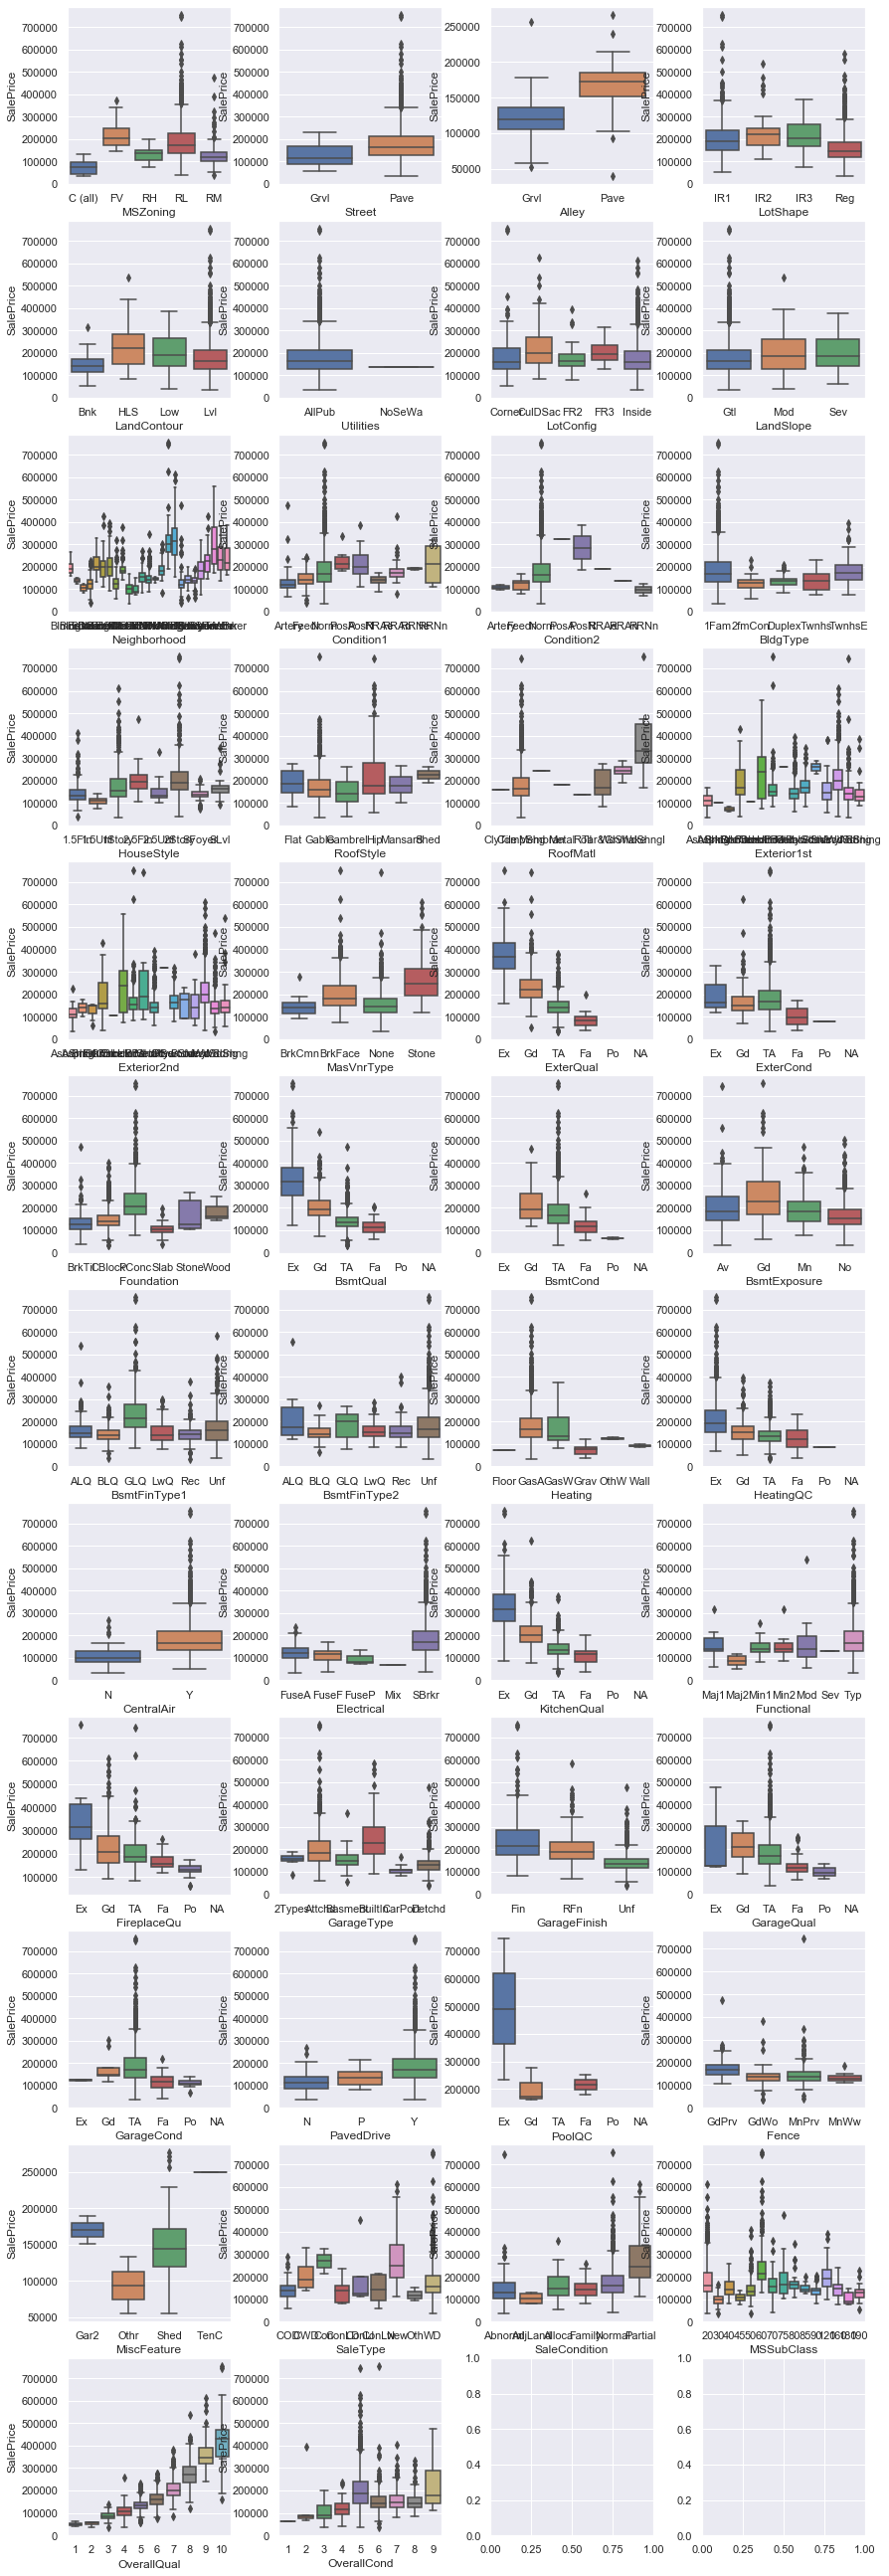

In [20]:
# Check the independent variables (categorical) distributions
fig, axes = plt.subplots(12, 4, figsize=(12, 36))
fig.tight_layout()
axes = axes.reshape(-1)
# Plot
for i, col in enumerate(cat_cols):
    sns.boxplot(x=col, y='SalePrice', data=df, ax=axes[i])

> There are some good categorical features, specifically those 'quality' features for overall, fireplace, kitchen, etc.. We will work on one hot encoding so that our regression models can make use of these.

## Missing data

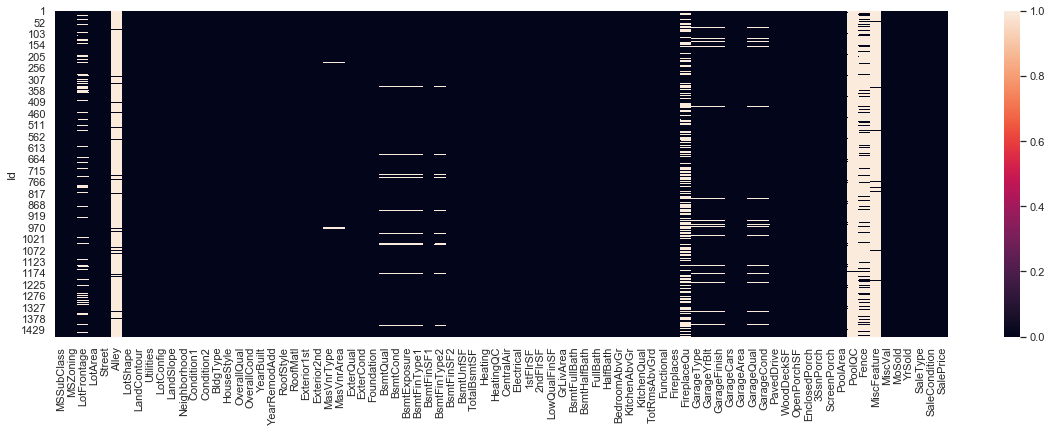

In [21]:
# Generate a heatmap showing where the missing values are
plt.figure(figsize=(20, 6))
sns.heatmap(df.isna())

In [22]:
# Ratio of missing values in training data
train_missing = (df.isna().sum()/len(df)).sort_values(ascending=False)
train_missing = train_missing[train_missing > 0]
train_missing

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageCond      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageYrBlt     0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [23]:
# Ratio of missing values in test data
test_missing = (df_test_raw.isna().sum()/len(df_test_raw)).sort_values(ascending=False)
test_missing = test_missing[test_missing > 0]
test_missing

PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageCond      0.053461
GarageQual      0.053461
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageType      0.052090
BsmtCond        0.030843
BsmtQual        0.030158
BsmtExposure    0.030158
BsmtFinType1    0.028787
BsmtFinType2    0.028787
MasVnrType      0.010966
MasVnrArea      0.010281
MSZoning        0.002742
BsmtHalfBath    0.001371
Utilities       0.001371
Functional      0.001371
BsmtFullBath    0.001371
BsmtFinSF2      0.000685
BsmtFinSF1      0.000685
Exterior2nd     0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
SaleType        0.000685
Exterior1st     0.000685
KitchenQual     0.000685
GarageArea      0.000685
GarageCars      0.000685
dtype: float64

In [24]:
# Columns with missing data in test set but not in training set
print(set(test_missing.index) - set(train_missing.index))

{'Functional', 'Utilities', 'GarageArea', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtHalfBath', 'Exterior1st', 'BsmtUnfSF', 'BsmtFinSF1', 'MSZoning', 'KitchenQual', 'GarageCars', 'Exterior2nd', 'SaleType', 'TotalBsmtSF'}


## Correlation

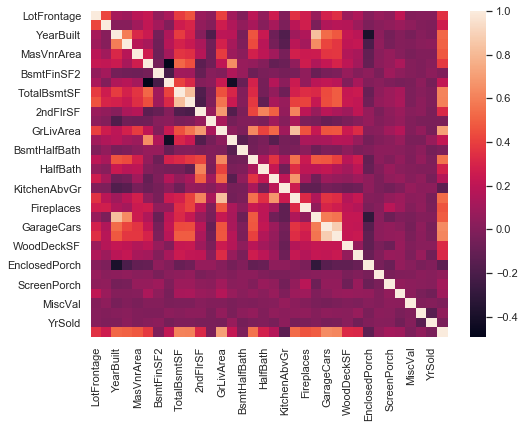

In [25]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr())

In [26]:
# Correlation with the dependent variable
corr = df.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

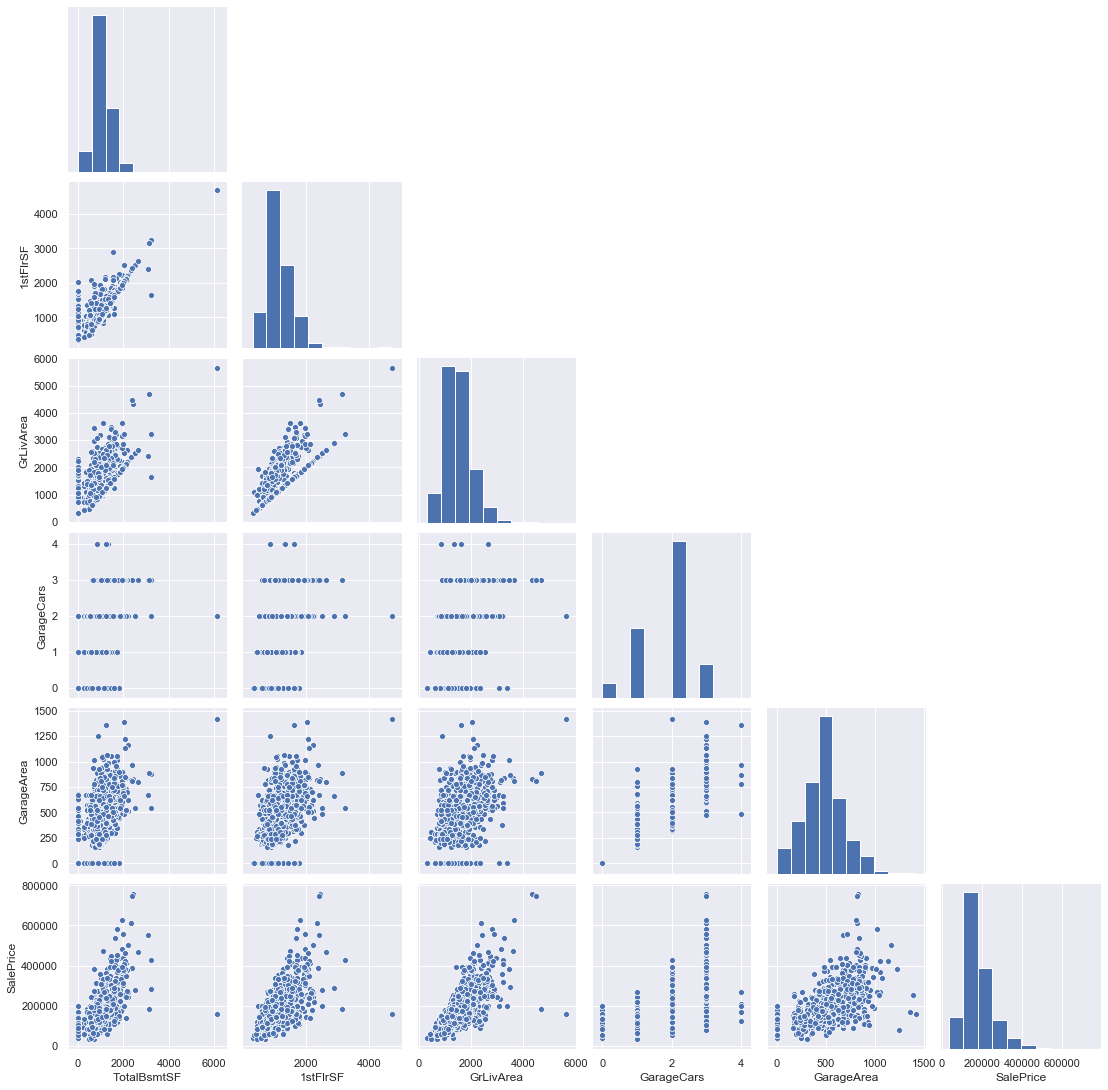

In [27]:
# Pairplot for those features with correlation >.6
sns.pairplot(df[corr[corr['SalePrice'] > .6].index], corner=True)

> There are some strange patterns, and we'll leave those alone at the moment.
* `1stFlrSF` vs `TotalBsmtSF`: There's a diagonal line showing 1st floor area = basement area.
* `GrLivArea` vs `TotalBsmtSF`: Again there's a diagonal line showing above ground area = basement area.

## Experiment: Features engineering

In [28]:
# Year from built to sold
df["Year_built_to_sold"] = np.maximum(df["YrSold"] - df["YearBuilt"], 0)
df.drop('YearBuilt', axis=1, inplace=True)

# Year from remod to sold
df["Year_remod_to_sold"] = np.maximum(df["YrSold"] - df["YearRemodAdd"], 0)
df.drop('YearRemodAdd', axis=1, inplace=True)

# Year from garage built to sold
df["Year_garageblt_to_sold"] = np.maximum(df["YrSold"] - df["GarageYrBlt"], 0)

# Drop remaining year columns
df.drop('YrSold', axis=1, inplace=True)

# Total area: basement + above ground
df["TotalArea"] = df["TotalBsmtSF"] + df["GrLivArea"]

In [29]:
# Check how the new features are performing
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice                 1.000000
TotalArea                 0.778959
GrLivArea                 0.708624
GarageCars                0.640409
GarageArea                0.623431
TotalBsmtSF               0.613581
1stFlrSF                  0.605852
FullBath                  0.560664
TotRmsAbvGrd              0.533723
GarageYrBlt               0.486362
MasVnrArea                0.477493
Fireplaces                0.466929
BsmtFinSF1                0.386420
LotFrontage               0.351799
WoodDeckSF                0.324413
2ndFlrSF                  0.319334
OpenPorchSF               0.315856
HalfBath                  0.284108
LotArea                   0.263843
BsmtFullBath              0.227122
BsmtUnfSF                 0.214479
BedroomAbvGr              0.168213
ScreenPorch               0.111447
PoolArea                  0.092404
MoSold                    0.046432
3SsnPorch                 0.044584
BsmtFinSF2               -0.011378
BsmtHalfBath             -0.016844
MiscVal             

# Data preparation

<hr>

**Summary:** We have built a pipeline for numerical features:
* impute with median
* features engineering with a custom transformer. And apply log transformation to the total area.
* standard scaling

And a separate pipeline for categorical features:
* fill missing values with 'NA'
* drop unwanted features
* one hot encoding, which ignores unseen category (appears only in test set but not training set)

Finally combine the two pipelines with a ColumnTransformer, so that we can easily fit and/or transform our datasets in just one line.

<hr>

## Custom transformer: Features creation

In [30]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    A custom transformer (for sklearn pipeline) to create additional numerical features.
    Put it after imputers in the pipeline as this does not handle df > array.
    """
    def __init__(self):
        self.YrSold = 32
        self.YearBuilt = 2
        self.YearRemodAdd = 3
        self.GarageYrBlt = 21
        self.TotalBsmtSF = 8
        self.GrLivArea = 12

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        # year related
        year_built_to_sold = np.maximum(X[:, self.YrSold] - X[:, self.YearBuilt], 0)
        year_remod_to_sold = np.maximum(X[:, self.YrSold] - X[:, self.YearRemodAdd], 0)
        year_garageblt_to_sold = np.maximum(X[:, self.YrSold] - X[:, self.GarageYrBlt], 0)
        # area related
        total_area = X[:, self.TotalBsmtSF] + X[:, self.GrLivArea]
        total_area = np.log1p(total_area)  # a good target of log transformation
        # drop the columns
        X = np.delete(X, [self.YrSold, self.YearBuilt, self.YearRemodAdd, self.GarageYrBlt], 1)
        return np.c_[X, year_built_to_sold, year_remod_to_sold, year_garageblt_to_sold, total_area]

In [31]:
class DropAttributes(BaseEstimator, TransformerMixin):
    """
    A custom transformer (for sklean pipeline) to remove unwanted categorical features.
    Put it after imputers in the pipeline as this does not handle df > array.
    """
    def __init__(self):
        self.PoolQC = 38
        self.MiscFeature = 40
        self.Alley = 2
        self.Fence = 39
        self.FireplaceQu = 32
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        # drop the columns
        X = np.delete(X, [self.PoolQC, self.MiscFeature, self.Alley, self.Fence, self.FireplaceQu], 1)
        return X

## Building the transformation pipeline

### Numerical pipeline

In [33]:
# The numerical pipeline
num_pipeline = Pipeline([
        ('median_imputer', SimpleImputer(strategy="median")),
        ('attr_adder', AttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

### Categorical pipeline

In [34]:
# The categorical pipeline
cat_pipeline = Pipeline([
        ('na_imputer', SimpleImputer(strategy='constant', fill_value='NA')),
        ('drop_attr', DropAttributes()),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))  # categories unseen in fitting will be ignored
    ])

### Combining the two

In [35]:
num_cols = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
cat_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'OverallCond']
print(len(num_cols), len(cat_cols))  # sum = 79

33 46


In [36]:
# The full pipeline
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ])

### Transform the training set and test set

In [37]:
# The well-prepared training set
X_train = full_pipeline.fit_transform(
    df_train_raw.set_index('Id').drop('SalePrice', axis=1)
)

In [38]:
# The dependent variable. Log transform it as observed in the EDA process
y = np.array(np.log(df_train_raw['SalePrice']))

In [39]:
# The well-prepared test set
X_test = full_pipeline.transform(df_test_raw.set_index('Id'))  # do not "fit" with test set

In [40]:
print(X_train.shape, y.shape, X_test.shape)  # equal number of columns

(1460, 312) (1460,) (1459, 312)


# Modeling

<hr>

**Summary:** First of all, predicting the housing sales price is a problem for supervised learning. We have the label `SalePrice` and 312 features after the preparation pipeline in the previous section. As this is not a big dataset, it does not make any difference whether we employ online or batch learning methods.

Ordinary least squares (OLS) is definitely going to overfit so I will start with L2 regularization (i.e., Ridge regression) as a baseline. This method will try to set the coefficients of features as small as possible, which can generalize better than OLS. Depends on the result, we may try with Lasso regression, which will perform feature selection (i.e., set the coefficients of unimportant features to zero), or a mix of both using Elastic Net.

<hr>

In [41]:
def print_grid_search_result(gs):
    """
    Print out
    * best hyperparameter set
    * best CV score
    * number of features of coef > 0
    """
    print('Best hyperparameter set: ', gs.best_params_)
    print('Best RMSE on CV: ', np.sqrt(-gs.best_score_))
    print('Number of features: ', np.array(grid_search.best_estimator_.coef_ != 0).sum())

In [42]:
def train_and_evaluate(X, y, model):
    """
    To prepare a df for plotting learning curve.
    """
    train_sizes, train_scores, cv_scores = learning_curve(
        model, X, y, scoring='neg_mean_squared_error', cv=5)
    train_rmse = np.sqrt(-train_scores.mean(1))
    cv_rmse = np.sqrt(-cv_scores.mean(1))
    df_learning_curve = pd.DataFrame({"Train Sizes": train_sizes,
                                      "Train RMSE": train_rmse,
                                      "CV RMSE": cv_rmse})
    return df_learning_curve

## Ridge regression

In [43]:
# parameter grid
param_grid = [
    {'alpha': [.01, .1, 1, 10, 20, 30]}
]

# Ridge regression with everything default
ridge_reg = Ridge()

# Grid search
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.01, 0.1, 1, 10, 20, 30]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [44]:
# Grid search result
print_grid_search_result(grid_search)

Best hyperparameter set:  {'alpha': 10}
Best RMSE on CV:  0.129445750640185
Number of features:  312


In [45]:
# The learning curve
res = train_and_evaluate(X_train, y, grid_search.best_estimator_)

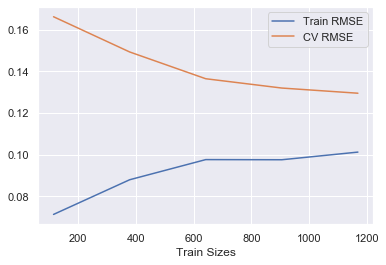

In [46]:
res.plot.line(x=0)

> **Observations:** The best Ridge regression model (alpha=10) overfits quite a lot. Let's try to reduce some features with Lasso instead.

## Lasso

In [47]:
# parameter grid
param_grid = [
    {'alpha': [.0002, .0005, .001, .01, .1, 1]}
]

# Ridge regression with everything default
lasso_reg = Lasso(random_state=42, selection='random', max_iter=10_000)

# Grid search
grid_search = GridSearchCV(lasso_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='random', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0002, 0.0005, 0.001, 0.01, 0.1, 1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [48]:
# Grid search result
print_grid_search_result(grid_search)

Best hyperparameter set:  {'alpha': 0.0005}
Best RMSE on CV:  0.12616047893055832
Number of features:  130


In [49]:
# The learning curve
res = train_and_evaluate(X_train, y, grid_search.best_estimator_)

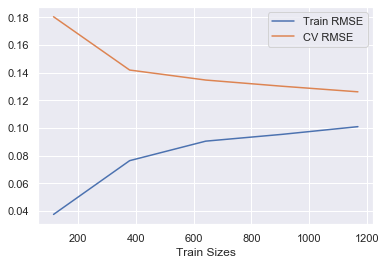

In [50]:
res.plot.line(x=0)

> **Observations:** The best Lasso regression (alpha=0.0005) is still overfitting, but with a lower RMSE than Ridge regression in this test. What about a combination of both using ElasticNet?

In [51]:
# Saving the best model (Lasso) so far
joblib.dump(grid_search.best_estimator_, f'{PATH_DATA}/lasso.pkl')

['./datasets/lasso.pkl']

## ElasticNet

In [52]:
# parameter grid
param_grid = [
    {'alpha': [.0002, .0005, .001, .01, .1, .5, 1],
     'l1_ratio': [.25, .5, .75, .9]}
]


# Ridge regression with everything default
elastic_net = ElasticNet(max_iter=10_000)

# Grid search
grid_search = GridSearchCV(elastic_net, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=10000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0002, 0.0005, 0.001, 0.01, 0.1, 0.5, 1],
                          'l1_ratio': [0.25, 0.5, 0.75, 0.9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [53]:
# Grid search result
print_grid_search_result(grid_search)

Best hyperparameter set:  {'alpha': 0.0005, 'l1_ratio': 0.75}
Best RMSE on CV:  0.1257882534086034
Number of features:  138


In [54]:
# The learning curve
res = train_and_evaluate(X_train, y, grid_search.best_estimator_)

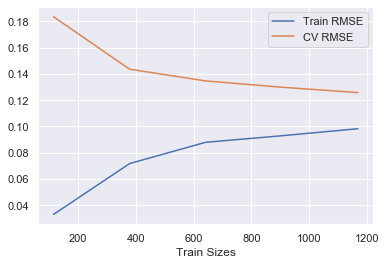

In [55]:
res.plot.line(x=0)

> **Observations:** ElasticNet is still overfitting and performs a bit better than Lasso regression.

In [56]:
# Saving the model
joblib.dump(grid_search.best_estimator_, f'{PATH_DATA}/elasticnet.pkl')

['./datasets/elasticnet.pkl']

## Pick the best model

### Retrain with the whole training set

In [57]:
# Load the best model that we've dumped to pickle earlier
# Lasso in this run as it performs quite well with the least number of features
m = joblib.load(f'{PATH_DATA}/lasso.pkl')

In [58]:
# Retrain the model with the whole training set
m = Lasso(**m.get_params())
m.fit(X_train, y)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='random', tol=0.0001, warm_start=False)

### Coefficients of each features

In [59]:
# Get back the feature names after the numerical pipeline
num_cols.remove('YrSold')
num_cols.remove('YearBuilt')
num_cols.remove('YearRemodAdd')
num_cols.remove('GarageYrBlt')
num_cols.append('year_built_to_sold')
num_cols.append('year_remod_to_sold')
num_cols.append('year_garageblt_to_sold')
num_cols.append('total_area')

# Get back the feature names after one hot encoding
cat_cols.remove('PoolQC')
cat_cols.remove('MiscFeature')
cat_cols.remove('Alley')
cat_cols.remove('Fence')
cat_cols.remove('FireplaceQu')
final_features_cat = full_pipeline.named_transformers_.cat.named_steps.ohe.get_feature_names(cat_cols)
final_features = np.concatenate((num_cols, final_features_cat))

# Verify the lengths
print(len(final_features), len(m.coef_)) # 312

312 312


In [60]:
# Assemble as a data frame
df_feature_importance = pd.DataFrame({
    'feature': final_features,
    'coef': m.coef_
})

In [61]:
df_feature_importance.describe()

,coef
count,312.000000
mean,0.001396
std,0.036431
min,-0.336869
25%,-0.000000
50%,0.000000
75%,-0.000000
max,0.208730


## Predict

In [62]:
y_test = np.exp(m.predict(X_test))  # y was log-transformed

In [63]:
submission = pd.DataFrame({'Id': df_test_raw['Id'], 'SalePrice': y_test})
submission.to_csv(f'{PATH_DATA}/submission.csv', index=False)

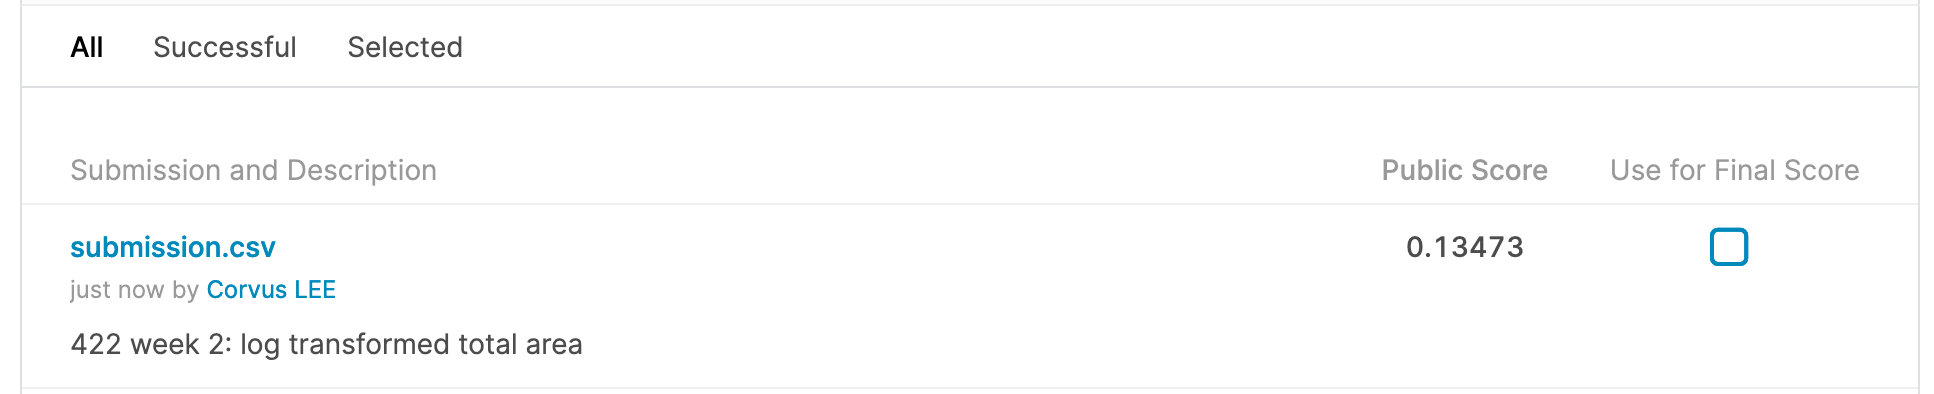

# Recommendations

<hr>

**Summary:** After carefully using grid search to fine tune the three linear regression models, all are performing equally well in the cross-validation score (RMSE):
* Ridge regression: 0.1294 -- 312 features
* Lasso regression: 0.1261 -- 130 features
* Elastic Net: 0.1257 -- 138 features

However, Lasso regression and Elastic Net have an advantage that they both include feature selection. And less number of features usually mean better interpretability. Our final model is Lasso regression.

Note that all models have overfitting problem, and the predicted sales price is not really accurate. But with the features importance, it is a good starting point to complement conventional methods. For example, we can start discussing the coefficients of all `Neighborhood` and whether it makes sense to people with that domain knowledge. We can also discuss the negative effects of MSZoning in commercial (-0.35), or a larger basement area (-0.8), etc.

This follows the CRISP-DM process: After machine learning model evaluation, goes to business understanding, and repeat the data collection/preparation/modeling/evaluation cycle.


<hr>

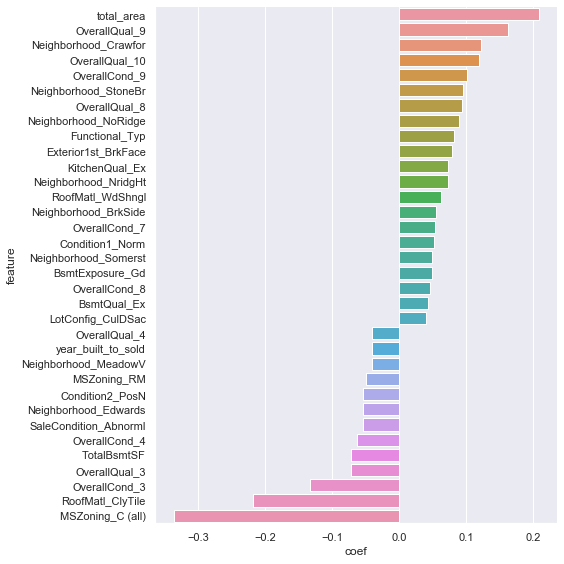

In [64]:
# Features importance - where coef > +- 1SD
data = df_feature_importance[
    abs(df_feature_importance['coef']) > np.std(df_feature_importance['coef'])
].sort_values('coef', ascending=False)

sns.catplot(x='coef', y='feature', data=data, kind='bar', height=8)